In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(random_seed)
random.seed(random_seed)

# 데이터 살펴보기

In [3]:
path = '/data/competition/Dacon/lg/'
sample = glob(f'{path}train/*')[100]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [4]:
# csv
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-11-03 15:30:00,18.3,18.5,18.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-11-03 15:20:00,17.8,18.1,17.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-11-03 15:10:00,17.4,17.6,17.2,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-11-03 15:00:00,17.9,18.1,17.6,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-11-03 14:50:00,18.1,18.2,17.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
5,2021-11-03 14:40:00,18.2,18.4,18.0,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
6,2021-11-03 14:30:00,18.4,18.5,18.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
7,2021-11-03 14:20:00,18.6,18.8,18.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
8,2021-11-03 14:10:00,19.5,19.7,19.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
9,2021-11-03 14:00:00,19.7,19.8,19.6,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [5]:
sample_image.shape

(512, 384, 3)

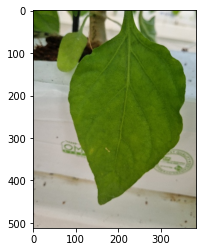

In [6]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
# json
sample_json

{'description': {'date': '20211103',
  'image': '55626.jpg',
  'task': 2,
  'width': 384,
  'time': '1538',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': 'b6',
  'grow': 13,
  'bbox': [{'x': 82.365234375,
    'h': 437.5513082837302,
    'y': 20.99362327938988,
    'w': 275.89707341269843}],
  'part': [{'x': 87.05323040674604,
    'h': 424.39093501984127,
    'y': 28.4182865203373,
    'id': 0,
    'w': 265.3489583333333}],
  'risk': 1,
  'crop': 3}}

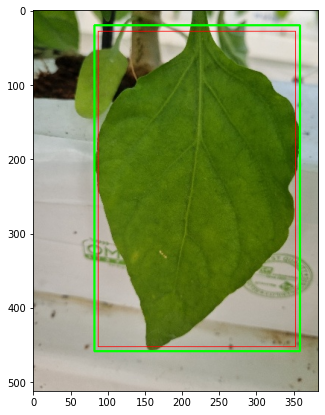

In [8]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

In [9]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob(path+'train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [01:02<00:00, 91.63it/s]


{'내부 온도 1 평균': [3.4, 47.3],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 이슬점 평균': [0.1, 34.5],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4]}

## CustomDataset 제작

In [10]:
# # 변수 설명 csv 파일 참조
# crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
# disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
#            '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
#            '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
#            '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
#            '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
#            '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
# risk = {'1':'초기','2':'중기','3':'말기'}

In [11]:
train_csv = sorted(glob(path+'train/*/*.csv'))
train_jpg = sorted(glob(path+'train/*/*.jpg'))
train_json = sorted(glob(path+'train/*/*.json'))


crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

labels = [label_unique[k] for k in labels]

In [12]:
label_encoder = {key:idx for idx, key in enumerate(label_unique)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [13]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train', transforms=None):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder
        self.transforms = transforms

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
#         img = img.astype(np.float32)/255
#         img = np.transpose(img, (2,0,1))
        
        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.as_tensor(img, dtype=torch.float32),
                'csv_feature' : torch.as_tensor(csv_feature, dtype=torch.float32),
                'label' : torch.as_tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.as_tensor(img, dtype=torch.float32),
                'csv_feature' : torch.as_tensor(csv_feature, dtype=torch.float32)
            }

# 하이퍼파라미터 및 변수

In [14]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
batch_size = 64
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 64
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 100
vision_pretrain = True
save_path = '/workspace/dacon/reg404_LSTM_25.pt'

# Data Aug

In [15]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize, Rotate,
    ShiftScaleRotate, CenterCrop, Resize, Rotate, RandomShadow, RandomSizedBBoxSafeCrop,
    ChannelShuffle, MotionBlur
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(512, 512),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_valid_transforms():
    return Compose([
            CenterCrop(512, 512, p=1.),
            Resize(512, 512),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_inference_transforms1():
    return Compose([
            OneOf([
                Resize(512, 512, p=1.),
                CenterCrop(512, 512, p=1.),
                RandomResizedCrop(512, 512, p=1.)
            ], p=1.), 
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Resize(512, 512),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_inference_transforms2():
    return Compose([
            OneOf([
                Resize(512, 512, p=1.),
                CenterCrop(512, 512, p=1.),
                RandomResizedCrop(512, 512, p=1.)
            ], p=1.), 
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Resize(512, 512),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# 데이터셋 구성

In [16]:
train = sorted(glob(path + 'train/*'))
test = sorted(glob(path + 'test/*'))

labelsss = pd.read_csv(path + 'train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [17]:
train_dataset = CustomDataset(train, transforms=get_train_transforms())
val_dataset = CustomDataset(val, transforms=get_valid_transforms())
test_dataset = CustomDataset(test, mode = 'test', transforms=get_inference_transforms1())

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=0,
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             num_workers=0,
                                             shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              num_workers=0,
                                              shuffle=False)

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


# 모델

## 이미지 분류 모델 : 
- 'vit_base_resnet50d_224' = 0.84798
- 'regnety_016' = 0.90029
- 'regnety_032' = 0.90648
- 'regnety_040' = 0.92947
- 'regnety_064' = 0.92375
- 'regnety_080' = 


In [18]:
import timm

class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
#         self.model = models.resnet50(pretrained=True)
        self.model = timm.create_model('regnety_040', pretrained=True)
#         self.model.head == nn.Sequential(
#                             nn.AdaptiveAvgPool2d((1,1)),
#                             nn.Flatten()
#         )
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [19]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.gru = nn.GRU(max_len, embedding_dim)
  
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.gru(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

## 앙상블

In [20]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [21]:
model = CNN2RNN(max_len=max_len,
                embedding_dim=embedding_dim,
                num_features=num_features,
                class_n=class_n,
                rate=dropout_rate)

model = model.to(device)

# 학습

In [22]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        """
        Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [23]:
import apex.amp as amp
from torch_poly_lr_decay import PolynomialLRDecay

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                 T_0=50,
                                                                 T_mult=1,
                                                                 eta_min=0.01)
scaler = torch.cuda.amp.GradScaler()
decay_steps = (len (train_dataset) // batch_size + 1) * epochs
plr = PolynomialLRDecay(optimizer, max_decay_steps=decay_steps, end_learning_rate=1e-6, power=0.9)

# criterion = nn.CrossEntropyLoss(weight)
criterion = LabelSmoothingCrossEntropy()

In [24]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    
    img = batch_item['img'].cuda()
    csv_feature = batch_item['csv_feature'].cuda()
    label = batch_item['label'].cuda()
    
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step(loss)

        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [25]:
model = nn.DataParallel(model)

In [26]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
#         tqdm_dataset.set_postfix({
#             'Epoch': epoch + 1,
#             'Loss': '{:06f}'.format(batch_loss.item()),
#             'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
#             'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
#         })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    plr.step()
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
        
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
#         torch.save(model.state_dict(), save_path)
        torch.save(model.module.state_dict(), save_path)

73it [05:44,  4.41s/it]
19it [00:35,  1.55s/it, Epoch=1, Val Loss=1.031969, Mean Val Loss=0.923531, Mean Val F-1=0.721622]
73it [04:24,  2.76s/it]
19it [00:20,  1.15it/s, Epoch=2, Val Loss=0.980284, Mean Val Loss=0.873492, Mean Val F-1=0.764277]
73it [04:20,  2.76s/it]
19it [00:20,  1.17it/s, Epoch=3, Val Loss=1.114248, Mean Val Loss=0.855602, Mean Val F-1=0.807114]
73it [04:25,  2.76s/it]
19it [00:19,  1.21it/s, Epoch=4, Val Loss=0.754211, Mean Val Loss=0.815074, Mean Val F-1=0.838572]
73it [04:25,  2.75s/it]
19it [00:20,  1.17it/s, Epoch=5, Val Loss=0.706181, Mean Val Loss=0.773721, Mean Val F-1=0.839900]
73it [04:24,  2.76s/it]
19it [00:20,  1.17it/s, Epoch=6, Val Loss=0.688784, Mean Val Loss=0.748227, Mean Val F-1=0.890004]
73it [04:28,  2.76s/it]
19it [00:20,  1.20it/s, Epoch=7, Val Loss=0.729842, Mean Val Loss=0.758265, Mean Val F-1=0.896172]
73it [04:24,  2.77s/it]
19it [00:21,  1.14it/s, Epoch=8, Val Loss=0.808724, Mean Val Loss=0.744073, Mean Val F-1=0.883197]
73it [04:23,  2.

73it [04:23,  2.73s/it]
19it [00:20,  1.18it/s, Epoch=67, Val Loss=0.694385, Mean Val Loss=0.700862, Mean Val F-1=0.917606]
73it [04:20,  2.75s/it]
19it [00:20,  1.17it/s, Epoch=68, Val Loss=0.685401, Mean Val Loss=0.717374, Mean Val F-1=0.925750]
73it [04:25,  2.77s/it]
19it [00:19,  1.29it/s, Epoch=69, Val Loss=0.684864, Mean Val Loss=0.695521, Mean Val F-1=0.936913]
73it [04:24,  2.75s/it]
19it [00:20,  1.18it/s, Epoch=70, Val Loss=0.650182, Mean Val Loss=0.698296, Mean Val F-1=0.911134]
73it [04:21,  2.74s/it]
19it [00:20,  1.17it/s, Epoch=71, Val Loss=0.640506, Mean Val Loss=0.699603, Mean Val F-1=0.923505]
73it [04:26,  2.77s/it]
19it [00:20,  1.21it/s, Epoch=72, Val Loss=0.636040, Mean Val Loss=0.705657, Mean Val F-1=0.921943]
73it [04:21,  2.77s/it]
19it [00:20,  1.16it/s, Epoch=73, Val Loss=0.676017, Mean Val Loss=0.692349, Mean Val F-1=0.928846]
73it [04:21,  2.77s/it]
19it [00:20,  1.21it/s, Epoch=74, Val Loss=0.667340, Mean Val Loss=0.716683, Mean Val F-1=0.898903]
73it [04

# 학습 결과

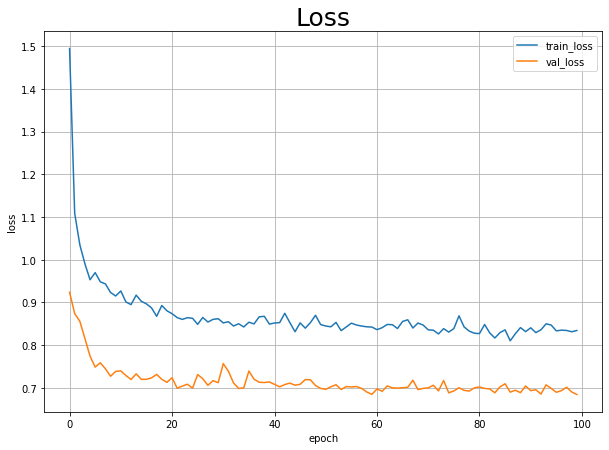

In [27]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

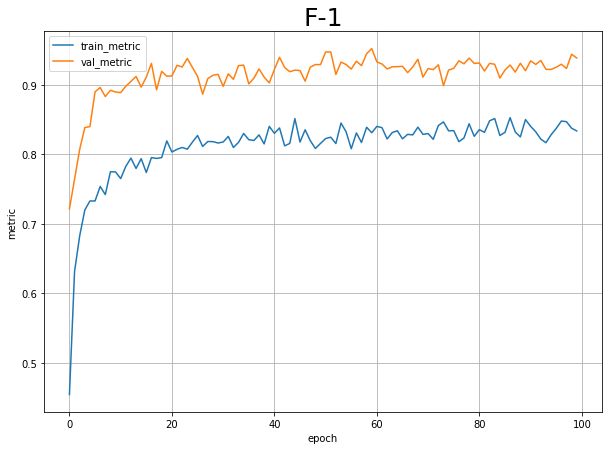

In [28]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

# 추론

In [29]:
model.load_state_dict(torch.load(save_path, map_location=device))

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.cnn.model.stem.conv.weight", "module.cnn.model.stem.bn.weight", "module.cnn.model.stem.bn.bias", "module.cnn.model.stem.bn.running_mean", "module.cnn.model.stem.bn.running_var", "module.cnn.model.s1.b1.conv1.conv.weight", "module.cnn.model.s1.b1.conv1.bn.weight", "module.cnn.model.s1.b1.conv1.bn.bias", "module.cnn.model.s1.b1.conv1.bn.running_mean", "module.cnn.model.s1.b1.conv1.bn.running_var", "module.cnn.model.s1.b1.conv2.conv.weight", "module.cnn.model.s1.b1.conv2.bn.weight", "module.cnn.model.s1.b1.conv2.bn.bias", "module.cnn.model.s1.b1.conv2.bn.running_mean", "module.cnn.model.s1.b1.conv2.bn.running_var", "module.cnn.model.s1.b1.se.fc1.weight", "module.cnn.model.s1.b1.se.fc1.bias", "module.cnn.model.s1.b1.se.fc2.weight", "module.cnn.model.s1.b1.se.fc2.bias", "module.cnn.model.s1.b1.conv3.conv.weight", "module.cnn.model.s1.b1.conv3.bn.weight", "module.cnn.model.s1.b1.conv3.bn.bias", "module.cnn.model.s1.b1.conv3.bn.running_mean", "module.cnn.model.s1.b1.conv3.bn.running_var", "module.cnn.model.s1.b1.downsample.conv.weight", "module.cnn.model.s1.b1.downsample.bn.weight", "module.cnn.model.s1.b1.downsample.bn.bias", "module.cnn.model.s1.b1.downsample.bn.running_mean", "module.cnn.model.s1.b1.downsample.bn.running_var", "module.cnn.model.s1.b2.conv1.conv.weight", "module.cnn.model.s1.b2.conv1.bn.weight", "module.cnn.model.s1.b2.conv1.bn.bias", "module.cnn.model.s1.b2.conv1.bn.running_mean", "module.cnn.model.s1.b2.conv1.bn.running_var", "module.cnn.model.s1.b2.conv2.conv.weight", "module.cnn.model.s1.b2.conv2.bn.weight", "module.cnn.model.s1.b2.conv2.bn.bias", "module.cnn.model.s1.b2.conv2.bn.running_mean", "module.cnn.model.s1.b2.conv2.bn.running_var", "module.cnn.model.s1.b2.se.fc1.weight", "module.cnn.model.s1.b2.se.fc1.bias", "module.cnn.model.s1.b2.se.fc2.weight", "module.cnn.model.s1.b2.se.fc2.bias", "module.cnn.model.s1.b2.conv3.conv.weight", "module.cnn.model.s1.b2.conv3.bn.weight", "module.cnn.model.s1.b2.conv3.bn.bias", "module.cnn.model.s1.b2.conv3.bn.running_mean", "module.cnn.model.s1.b2.conv3.bn.running_var", "module.cnn.model.s2.b1.conv1.conv.weight", "module.cnn.model.s2.b1.conv1.bn.weight", "module.cnn.model.s2.b1.conv1.bn.bias", "module.cnn.model.s2.b1.conv1.bn.running_mean", "module.cnn.model.s2.b1.conv1.bn.running_var", "module.cnn.model.s2.b1.conv2.conv.weight", "module.cnn.model.s2.b1.conv2.bn.weight", "module.cnn.model.s2.b1.conv2.bn.bias", "module.cnn.model.s2.b1.conv2.bn.running_mean", "module.cnn.model.s2.b1.conv2.bn.running_var", "module.cnn.model.s2.b1.se.fc1.weight", "module.cnn.model.s2.b1.se.fc1.bias", "module.cnn.model.s2.b1.se.fc2.weight", "module.cnn.model.s2.b1.se.fc2.bias", "module.cnn.model.s2.b1.conv3.conv.weight", "module.cnn.model.s2.b1.conv3.bn.weight", "module.cnn.model.s2.b1.conv3.bn.bias", "module.cnn.model.s2.b1.conv3.bn.running_mean", "module.cnn.model.s2.b1.conv3.bn.running_var", "module.cnn.model.s2.b1.downsample.conv.weight", "module.cnn.model.s2.b1.downsample.bn.weight", "module.cnn.model.s2.b1.downsample.bn.bias", "module.cnn.model.s2.b1.downsample.bn.running_mean", "module.cnn.model.s2.b1.downsample.bn.running_var", "module.cnn.model.s2.b2.conv1.conv.weight", "module.cnn.model.s2.b2.conv1.bn.weight", "module.cnn.model.s2.b2.conv1.bn.bias", "module.cnn.model.s2.b2.conv1.bn.running_mean", "module.cnn.model.s2.b2.conv1.bn.running_var", "module.cnn.model.s2.b2.conv2.conv.weight", "module.cnn.model.s2.b2.conv2.bn.weight", "module.cnn.model.s2.b2.conv2.bn.bias", "module.cnn.model.s2.b2.conv2.bn.running_mean", "module.cnn.model.s2.b2.conv2.bn.running_var", "module.cnn.model.s2.b2.se.fc1.weight", "module.cnn.model.s2.b2.se.fc1.bias", "module.cnn.model.s2.b2.se.fc2.weight", "module.cnn.model.s2.b2.se.fc2.bias", "module.cnn.model.s2.b2.conv3.conv.weight", "module.cnn.model.s2.b2.conv3.bn.weight", "module.cnn.model.s2.b2.conv3.bn.bias", "module.cnn.model.s2.b2.conv3.bn.running_mean", "module.cnn.model.s2.b2.conv3.bn.running_var", "module.cnn.model.s2.b3.conv1.conv.weight", "module.cnn.model.s2.b3.conv1.bn.weight", "module.cnn.model.s2.b3.conv1.bn.bias", "module.cnn.model.s2.b3.conv1.bn.running_mean", "module.cnn.model.s2.b3.conv1.bn.running_var", "module.cnn.model.s2.b3.conv2.conv.weight", "module.cnn.model.s2.b3.conv2.bn.weight", "module.cnn.model.s2.b3.conv2.bn.bias", "module.cnn.model.s2.b3.conv2.bn.running_mean", "module.cnn.model.s2.b3.conv2.bn.running_var", "module.cnn.model.s2.b3.se.fc1.weight", "module.cnn.model.s2.b3.se.fc1.bias", "module.cnn.model.s2.b3.se.fc2.weight", "module.cnn.model.s2.b3.se.fc2.bias", "module.cnn.model.s2.b3.conv3.conv.weight", "module.cnn.model.s2.b3.conv3.bn.weight", "module.cnn.model.s2.b3.conv3.bn.bias", "module.cnn.model.s2.b3.conv3.bn.running_mean", "module.cnn.model.s2.b3.conv3.bn.running_var", "module.cnn.model.s2.b4.conv1.conv.weight", "module.cnn.model.s2.b4.conv1.bn.weight", "module.cnn.model.s2.b4.conv1.bn.bias", "module.cnn.model.s2.b4.conv1.bn.running_mean", "module.cnn.model.s2.b4.conv1.bn.running_var", "module.cnn.model.s2.b4.conv2.conv.weight", "module.cnn.model.s2.b4.conv2.bn.weight", "module.cnn.model.s2.b4.conv2.bn.bias", "module.cnn.model.s2.b4.conv2.bn.running_mean", "module.cnn.model.s2.b4.conv2.bn.running_var", "module.cnn.model.s2.b4.se.fc1.weight", "module.cnn.model.s2.b4.se.fc1.bias", "module.cnn.model.s2.b4.se.fc2.weight", "module.cnn.model.s2.b4.se.fc2.bias", "module.cnn.model.s2.b4.conv3.conv.weight", "module.cnn.model.s2.b4.conv3.bn.weight", "module.cnn.model.s2.b4.conv3.bn.bias", "module.cnn.model.s2.b4.conv3.bn.running_mean", "module.cnn.model.s2.b4.conv3.bn.running_var", "module.cnn.model.s2.b5.conv1.conv.weight", "module.cnn.model.s2.b5.conv1.bn.weight", "module.cnn.model.s2.b5.conv1.bn.bias", "module.cnn.model.s2.b5.conv1.bn.running_mean", "module.cnn.model.s2.b5.conv1.bn.running_var", "module.cnn.model.s2.b5.conv2.conv.weight", "module.cnn.model.s2.b5.conv2.bn.weight", "module.cnn.model.s2.b5.conv2.bn.bias", "module.cnn.model.s2.b5.conv2.bn.running_mean", "module.cnn.model.s2.b5.conv2.bn.running_var", "module.cnn.model.s2.b5.se.fc1.weight", "module.cnn.model.s2.b5.se.fc1.bias", "module.cnn.model.s2.b5.se.fc2.weight", "module.cnn.model.s2.b5.se.fc2.bias", "module.cnn.model.s2.b5.conv3.conv.weight", "module.cnn.model.s2.b5.conv3.bn.weight", "module.cnn.model.s2.b5.conv3.bn.bias", "module.cnn.model.s2.b5.conv3.bn.running_mean", "module.cnn.model.s2.b5.conv3.bn.running_var", "module.cnn.model.s2.b6.conv1.conv.weight", "module.cnn.model.s2.b6.conv1.bn.weight", "module.cnn.model.s2.b6.conv1.bn.bias", "module.cnn.model.s2.b6.conv1.bn.running_mean", "module.cnn.model.s2.b6.conv1.bn.running_var", "module.cnn.model.s2.b6.conv2.conv.weight", "module.cnn.model.s2.b6.conv2.bn.weight", "module.cnn.model.s2.b6.conv2.bn.bias", "module.cnn.model.s2.b6.conv2.bn.running_mean", "module.cnn.model.s2.b6.conv2.bn.running_var", "module.cnn.model.s2.b6.se.fc1.weight", "module.cnn.model.s2.b6.se.fc1.bias", "module.cnn.model.s2.b6.se.fc2.weight", "module.cnn.model.s2.b6.se.fc2.bias", "module.cnn.model.s2.b6.conv3.conv.weight", "module.cnn.model.s2.b6.conv3.bn.weight", "module.cnn.model.s2.b6.conv3.bn.bias", "module.cnn.model.s2.b6.conv3.bn.running_mean", "module.cnn.model.s2.b6.conv3.bn.running_var", "module.cnn.model.s3.b1.conv1.conv.weight", "module.cnn.model.s3.b1.conv1.bn.weight", "module.cnn.model.s3.b1.conv1.bn.bias", "module.cnn.model.s3.b1.conv1.bn.running_mean", "module.cnn.model.s3.b1.conv1.bn.running_var", "module.cnn.model.s3.b1.conv2.conv.weight", "module.cnn.model.s3.b1.conv2.bn.weight", "module.cnn.model.s3.b1.conv2.bn.bias", "module.cnn.model.s3.b1.conv2.bn.running_mean", "module.cnn.model.s3.b1.conv2.bn.running_var", "module.cnn.model.s3.b1.se.fc1.weight", "module.cnn.model.s3.b1.se.fc1.bias", "module.cnn.model.s3.b1.se.fc2.weight", "module.cnn.model.s3.b1.se.fc2.bias", "module.cnn.model.s3.b1.conv3.conv.weight", "module.cnn.model.s3.b1.conv3.bn.weight", "module.cnn.model.s3.b1.conv3.bn.bias", "module.cnn.model.s3.b1.conv3.bn.running_mean", "module.cnn.model.s3.b1.conv3.bn.running_var", "module.cnn.model.s3.b1.downsample.conv.weight", "module.cnn.model.s3.b1.downsample.bn.weight", "module.cnn.model.s3.b1.downsample.bn.bias", "module.cnn.model.s3.b1.downsample.bn.running_mean", "module.cnn.model.s3.b1.downsample.bn.running_var", "module.cnn.model.s3.b2.conv1.conv.weight", "module.cnn.model.s3.b2.conv1.bn.weight", "module.cnn.model.s3.b2.conv1.bn.bias", "module.cnn.model.s3.b2.conv1.bn.running_mean", "module.cnn.model.s3.b2.conv1.bn.running_var", "module.cnn.model.s3.b2.conv2.conv.weight", "module.cnn.model.s3.b2.conv2.bn.weight", "module.cnn.model.s3.b2.conv2.bn.bias", "module.cnn.model.s3.b2.conv2.bn.running_mean", "module.cnn.model.s3.b2.conv2.bn.running_var", "module.cnn.model.s3.b2.se.fc1.weight", "module.cnn.model.s3.b2.se.fc1.bias", "module.cnn.model.s3.b2.se.fc2.weight", "module.cnn.model.s3.b2.se.fc2.bias", "module.cnn.model.s3.b2.conv3.conv.weight", "module.cnn.model.s3.b2.conv3.bn.weight", "module.cnn.model.s3.b2.conv3.bn.bias", "module.cnn.model.s3.b2.conv3.bn.running_mean", "module.cnn.model.s3.b2.conv3.bn.running_var", "module.cnn.model.s3.b3.conv1.conv.weight", "module.cnn.model.s3.b3.conv1.bn.weight", "module.cnn.model.s3.b3.conv1.bn.bias", "module.cnn.model.s3.b3.conv1.bn.running_mean", "module.cnn.model.s3.b3.conv1.bn.running_var", "module.cnn.model.s3.b3.conv2.conv.weight", "module.cnn.model.s3.b3.conv2.bn.weight", "module.cnn.model.s3.b3.conv2.bn.bias", "module.cnn.model.s3.b3.conv2.bn.running_mean", "module.cnn.model.s3.b3.conv2.bn.running_var", "module.cnn.model.s3.b3.se.fc1.weight", "module.cnn.model.s3.b3.se.fc1.bias", "module.cnn.model.s3.b3.se.fc2.weight", "module.cnn.model.s3.b3.se.fc2.bias", "module.cnn.model.s3.b3.conv3.conv.weight", "module.cnn.model.s3.b3.conv3.bn.weight", "module.cnn.model.s3.b3.conv3.bn.bias", "module.cnn.model.s3.b3.conv3.bn.running_mean", "module.cnn.model.s3.b3.conv3.bn.running_var", "module.cnn.model.s3.b4.conv1.conv.weight", "module.cnn.model.s3.b4.conv1.bn.weight", "module.cnn.model.s3.b4.conv1.bn.bias", "module.cnn.model.s3.b4.conv1.bn.running_mean", "module.cnn.model.s3.b4.conv1.bn.running_var", "module.cnn.model.s3.b4.conv2.conv.weight", "module.cnn.model.s3.b4.conv2.bn.weight", "module.cnn.model.s3.b4.conv2.bn.bias", "module.cnn.model.s3.b4.conv2.bn.running_mean", "module.cnn.model.s3.b4.conv2.bn.running_var", "module.cnn.model.s3.b4.se.fc1.weight", "module.cnn.model.s3.b4.se.fc1.bias", "module.cnn.model.s3.b4.se.fc2.weight", "module.cnn.model.s3.b4.se.fc2.bias", "module.cnn.model.s3.b4.conv3.conv.weight", "module.cnn.model.s3.b4.conv3.bn.weight", "module.cnn.model.s3.b4.conv3.bn.bias", "module.cnn.model.s3.b4.conv3.bn.running_mean", "module.cnn.model.s3.b4.conv3.bn.running_var", "module.cnn.model.s3.b5.conv1.conv.weight", "module.cnn.model.s3.b5.conv1.bn.weight", "module.cnn.model.s3.b5.conv1.bn.bias", "module.cnn.model.s3.b5.conv1.bn.running_mean", "module.cnn.model.s3.b5.conv1.bn.running_var", "module.cnn.model.s3.b5.conv2.conv.weight", "module.cnn.model.s3.b5.conv2.bn.weight", "module.cnn.model.s3.b5.conv2.bn.bias", "module.cnn.model.s3.b5.conv2.bn.running_mean", "module.cnn.model.s3.b5.conv2.bn.running_var", "module.cnn.model.s3.b5.se.fc1.weight", "module.cnn.model.s3.b5.se.fc1.bias", "module.cnn.model.s3.b5.se.fc2.weight", "module.cnn.model.s3.b5.se.fc2.bias", "module.cnn.model.s3.b5.conv3.conv.weight", "module.cnn.model.s3.b5.conv3.bn.weight", "module.cnn.model.s3.b5.conv3.bn.bias", "module.cnn.model.s3.b5.conv3.bn.running_mean", "module.cnn.model.s3.b5.conv3.bn.running_var", "module.cnn.model.s3.b6.conv1.conv.weight", "module.cnn.model.s3.b6.conv1.bn.weight", "module.cnn.model.s3.b6.conv1.bn.bias", "module.cnn.model.s3.b6.conv1.bn.running_mean", "module.cnn.model.s3.b6.conv1.bn.running_var", "module.cnn.model.s3.b6.conv2.conv.weight", "module.cnn.model.s3.b6.conv2.bn.weight", "module.cnn.model.s3.b6.conv2.bn.bias", "module.cnn.model.s3.b6.conv2.bn.running_mean", "module.cnn.model.s3.b6.conv2.bn.running_var", "module.cnn.model.s3.b6.se.fc1.weight", "module.cnn.model.s3.b6.se.fc1.bias", "module.cnn.model.s3.b6.se.fc2.weight", "module.cnn.model.s3.b6.se.fc2.bias", "module.cnn.model.s3.b6.conv3.conv.weight", "module.cnn.model.s3.b6.conv3.bn.weight", "module.cnn.model.s3.b6.conv3.bn.bias", "module.cnn.model.s3.b6.conv3.bn.running_mean", "module.cnn.model.s3.b6.conv3.bn.running_var", "module.cnn.model.s3.b7.conv1.conv.weight", "module.cnn.model.s3.b7.conv1.bn.weight", "module.cnn.model.s3.b7.conv1.bn.bias", "module.cnn.model.s3.b7.conv1.bn.running_mean", "module.cnn.model.s3.b7.conv1.bn.running_var", "module.cnn.model.s3.b7.conv2.conv.weight", "module.cnn.model.s3.b7.conv2.bn.weight", "module.cnn.model.s3.b7.conv2.bn.bias", "module.cnn.model.s3.b7.conv2.bn.running_mean", "module.cnn.model.s3.b7.conv2.bn.running_var", "module.cnn.model.s3.b7.se.fc1.weight", "module.cnn.model.s3.b7.se.fc1.bias", "module.cnn.model.s3.b7.se.fc2.weight", "module.cnn.model.s3.b7.se.fc2.bias", "module.cnn.model.s3.b7.conv3.conv.weight", "module.cnn.model.s3.b7.conv3.bn.weight", "module.cnn.model.s3.b7.conv3.bn.bias", "module.cnn.model.s3.b7.conv3.bn.running_mean", "module.cnn.model.s3.b7.conv3.bn.running_var", "module.cnn.model.s3.b8.conv1.conv.weight", "module.cnn.model.s3.b8.conv1.bn.weight", "module.cnn.model.s3.b8.conv1.bn.bias", "module.cnn.model.s3.b8.conv1.bn.running_mean", "module.cnn.model.s3.b8.conv1.bn.running_var", "module.cnn.model.s3.b8.conv2.conv.weight", "module.cnn.model.s3.b8.conv2.bn.weight", "module.cnn.model.s3.b8.conv2.bn.bias", "module.cnn.model.s3.b8.conv2.bn.running_mean", "module.cnn.model.s3.b8.conv2.bn.running_var", "module.cnn.model.s3.b8.se.fc1.weight", "module.cnn.model.s3.b8.se.fc1.bias", "module.cnn.model.s3.b8.se.fc2.weight", "module.cnn.model.s3.b8.se.fc2.bias", "module.cnn.model.s3.b8.conv3.conv.weight", "module.cnn.model.s3.b8.conv3.bn.weight", "module.cnn.model.s3.b8.conv3.bn.bias", "module.cnn.model.s3.b8.conv3.bn.running_mean", "module.cnn.model.s3.b8.conv3.bn.running_var", "module.cnn.model.s3.b9.conv1.conv.weight", "module.cnn.model.s3.b9.conv1.bn.weight", "module.cnn.model.s3.b9.conv1.bn.bias", "module.cnn.model.s3.b9.conv1.bn.running_mean", "module.cnn.model.s3.b9.conv1.bn.running_var", "module.cnn.model.s3.b9.conv2.conv.weight", "module.cnn.model.s3.b9.conv2.bn.weight", "module.cnn.model.s3.b9.conv2.bn.bias", "module.cnn.model.s3.b9.conv2.bn.running_mean", "module.cnn.model.s3.b9.conv2.bn.running_var", "module.cnn.model.s3.b9.se.fc1.weight", "module.cnn.model.s3.b9.se.fc1.bias", "module.cnn.model.s3.b9.se.fc2.weight", "module.cnn.model.s3.b9.se.fc2.bias", "module.cnn.model.s3.b9.conv3.conv.weight", "module.cnn.model.s3.b9.conv3.bn.weight", "module.cnn.model.s3.b9.conv3.bn.bias", "module.cnn.model.s3.b9.conv3.bn.running_mean", "module.cnn.model.s3.b9.conv3.bn.running_var", "module.cnn.model.s3.b10.conv1.conv.weight", "module.cnn.model.s3.b10.conv1.bn.weight", "module.cnn.model.s3.b10.conv1.bn.bias", "module.cnn.model.s3.b10.conv1.bn.running_mean", "module.cnn.model.s3.b10.conv1.bn.running_var", "module.cnn.model.s3.b10.conv2.conv.weight", "module.cnn.model.s3.b10.conv2.bn.weight", "module.cnn.model.s3.b10.conv2.bn.bias", "module.cnn.model.s3.b10.conv2.bn.running_mean", "module.cnn.model.s3.b10.conv2.bn.running_var", "module.cnn.model.s3.b10.se.fc1.weight", "module.cnn.model.s3.b10.se.fc1.bias", "module.cnn.model.s3.b10.se.fc2.weight", "module.cnn.model.s3.b10.se.fc2.bias", "module.cnn.model.s3.b10.conv3.conv.weight", "module.cnn.model.s3.b10.conv3.bn.weight", "module.cnn.model.s3.b10.conv3.bn.bias", "module.cnn.model.s3.b10.conv3.bn.running_mean", "module.cnn.model.s3.b10.conv3.bn.running_var", "module.cnn.model.s3.b11.conv1.conv.weight", "module.cnn.model.s3.b11.conv1.bn.weight", "module.cnn.model.s3.b11.conv1.bn.bias", "module.cnn.model.s3.b11.conv1.bn.running_mean", "module.cnn.model.s3.b11.conv1.bn.running_var", "module.cnn.model.s3.b11.conv2.conv.weight", "module.cnn.model.s3.b11.conv2.bn.weight", "module.cnn.model.s3.b11.conv2.bn.bias", "module.cnn.model.s3.b11.conv2.bn.running_mean", "module.cnn.model.s3.b11.conv2.bn.running_var", "module.cnn.model.s3.b11.se.fc1.weight", "module.cnn.model.s3.b11.se.fc1.bias", "module.cnn.model.s3.b11.se.fc2.weight", "module.cnn.model.s3.b11.se.fc2.bias", "module.cnn.model.s3.b11.conv3.conv.weight", "module.cnn.model.s3.b11.conv3.bn.weight", "module.cnn.model.s3.b11.conv3.bn.bias", "module.cnn.model.s3.b11.conv3.bn.running_mean", "module.cnn.model.s3.b11.conv3.bn.running_var", "module.cnn.model.s3.b12.conv1.conv.weight", "module.cnn.model.s3.b12.conv1.bn.weight", "module.cnn.model.s3.b12.conv1.bn.bias", "module.cnn.model.s3.b12.conv1.bn.running_mean", "module.cnn.model.s3.b12.conv1.bn.running_var", "module.cnn.model.s3.b12.conv2.conv.weight", "module.cnn.model.s3.b12.conv2.bn.weight", "module.cnn.model.s3.b12.conv2.bn.bias", "module.cnn.model.s3.b12.conv2.bn.running_mean", "module.cnn.model.s3.b12.conv2.bn.running_var", "module.cnn.model.s3.b12.se.fc1.weight", "module.cnn.model.s3.b12.se.fc1.bias", "module.cnn.model.s3.b12.se.fc2.weight", "module.cnn.model.s3.b12.se.fc2.bias", "module.cnn.model.s3.b12.conv3.conv.weight", "module.cnn.model.s3.b12.conv3.bn.weight", "module.cnn.model.s3.b12.conv3.bn.bias", "module.cnn.model.s3.b12.conv3.bn.running_mean", "module.cnn.model.s3.b12.conv3.bn.running_var", "module.cnn.model.s4.b1.conv1.conv.weight", "module.cnn.model.s4.b1.conv1.bn.weight", "module.cnn.model.s4.b1.conv1.bn.bias", "module.cnn.model.s4.b1.conv1.bn.running_mean", "module.cnn.model.s4.b1.conv1.bn.running_var", "module.cnn.model.s4.b1.conv2.conv.weight", "module.cnn.model.s4.b1.conv2.bn.weight", "module.cnn.model.s4.b1.conv2.bn.bias", "module.cnn.model.s4.b1.conv2.bn.running_mean", "module.cnn.model.s4.b1.conv2.bn.running_var", "module.cnn.model.s4.b1.se.fc1.weight", "module.cnn.model.s4.b1.se.fc1.bias", "module.cnn.model.s4.b1.se.fc2.weight", "module.cnn.model.s4.b1.se.fc2.bias", "module.cnn.model.s4.b1.conv3.conv.weight", "module.cnn.model.s4.b1.conv3.bn.weight", "module.cnn.model.s4.b1.conv3.bn.bias", "module.cnn.model.s4.b1.conv3.bn.running_mean", "module.cnn.model.s4.b1.conv3.bn.running_var", "module.cnn.model.s4.b1.downsample.conv.weight", "module.cnn.model.s4.b1.downsample.bn.weight", "module.cnn.model.s4.b1.downsample.bn.bias", "module.cnn.model.s4.b1.downsample.bn.running_mean", "module.cnn.model.s4.b1.downsample.bn.running_var", "module.cnn.model.s4.b2.conv1.conv.weight", "module.cnn.model.s4.b2.conv1.bn.weight", "module.cnn.model.s4.b2.conv1.bn.bias", "module.cnn.model.s4.b2.conv1.bn.running_mean", "module.cnn.model.s4.b2.conv1.bn.running_var", "module.cnn.model.s4.b2.conv2.conv.weight", "module.cnn.model.s4.b2.conv2.bn.weight", "module.cnn.model.s4.b2.conv2.bn.bias", "module.cnn.model.s4.b2.conv2.bn.running_mean", "module.cnn.model.s4.b2.conv2.bn.running_var", "module.cnn.model.s4.b2.se.fc1.weight", "module.cnn.model.s4.b2.se.fc1.bias", "module.cnn.model.s4.b2.se.fc2.weight", "module.cnn.model.s4.b2.se.fc2.bias", "module.cnn.model.s4.b2.conv3.conv.weight", "module.cnn.model.s4.b2.conv3.bn.weight", "module.cnn.model.s4.b2.conv3.bn.bias", "module.cnn.model.s4.b2.conv3.bn.running_mean", "module.cnn.model.s4.b2.conv3.bn.running_var", "module.cnn.model.head.fc.weight", "module.cnn.model.head.fc.bias", "module.rnn.gru.weight_ih_l0", "module.rnn.gru.weight_hh_l0", "module.rnn.gru.bias_ih_l0", "module.rnn.gru.bias_hh_l0", "module.rnn.rnn_fc.weight", "module.rnn.rnn_fc.bias", "module.rnn.final_layer.weight", "module.rnn.final_layer.bias". 
	Unexpected key(s) in state_dict: "cnn.model.stem.conv.weight", "cnn.model.stem.bn.weight", "cnn.model.stem.bn.bias", "cnn.model.stem.bn.running_mean", "cnn.model.stem.bn.running_var", "cnn.model.stem.bn.num_batches_tracked", "cnn.model.s1.b1.conv1.conv.weight", "cnn.model.s1.b1.conv1.bn.weight", "cnn.model.s1.b1.conv1.bn.bias", "cnn.model.s1.b1.conv1.bn.running_mean", "cnn.model.s1.b1.conv1.bn.running_var", "cnn.model.s1.b1.conv1.bn.num_batches_tracked", "cnn.model.s1.b1.conv2.conv.weight", "cnn.model.s1.b1.conv2.bn.weight", "cnn.model.s1.b1.conv2.bn.bias", "cnn.model.s1.b1.conv2.bn.running_mean", "cnn.model.s1.b1.conv2.bn.running_var", "cnn.model.s1.b1.conv2.bn.num_batches_tracked", "cnn.model.s1.b1.se.fc1.weight", "cnn.model.s1.b1.se.fc1.bias", "cnn.model.s1.b1.se.fc2.weight", "cnn.model.s1.b1.se.fc2.bias", "cnn.model.s1.b1.conv3.conv.weight", "cnn.model.s1.b1.conv3.bn.weight", "cnn.model.s1.b1.conv3.bn.bias", "cnn.model.s1.b1.conv3.bn.running_mean", "cnn.model.s1.b1.conv3.bn.running_var", "cnn.model.s1.b1.conv3.bn.num_batches_tracked", "cnn.model.s1.b1.downsample.conv.weight", "cnn.model.s1.b1.downsample.bn.weight", "cnn.model.s1.b1.downsample.bn.bias", "cnn.model.s1.b1.downsample.bn.running_mean", "cnn.model.s1.b1.downsample.bn.running_var", "cnn.model.s1.b1.downsample.bn.num_batches_tracked", "cnn.model.s1.b2.conv1.conv.weight", "cnn.model.s1.b2.conv1.bn.weight", "cnn.model.s1.b2.conv1.bn.bias", "cnn.model.s1.b2.conv1.bn.running_mean", "cnn.model.s1.b2.conv1.bn.running_var", "cnn.model.s1.b2.conv1.bn.num_batches_tracked", "cnn.model.s1.b2.conv2.conv.weight", "cnn.model.s1.b2.conv2.bn.weight", "cnn.model.s1.b2.conv2.bn.bias", "cnn.model.s1.b2.conv2.bn.running_mean", "cnn.model.s1.b2.conv2.bn.running_var", "cnn.model.s1.b2.conv2.bn.num_batches_tracked", "cnn.model.s1.b2.se.fc1.weight", "cnn.model.s1.b2.se.fc1.bias", "cnn.model.s1.b2.se.fc2.weight", "cnn.model.s1.b2.se.fc2.bias", "cnn.model.s1.b2.conv3.conv.weight", "cnn.model.s1.b2.conv3.bn.weight", "cnn.model.s1.b2.conv3.bn.bias", "cnn.model.s1.b2.conv3.bn.running_mean", "cnn.model.s1.b2.conv3.bn.running_var", "cnn.model.s1.b2.conv3.bn.num_batches_tracked", "cnn.model.s2.b1.conv1.conv.weight", "cnn.model.s2.b1.conv1.bn.weight", "cnn.model.s2.b1.conv1.bn.bias", "cnn.model.s2.b1.conv1.bn.running_mean", "cnn.model.s2.b1.conv1.bn.running_var", "cnn.model.s2.b1.conv1.bn.num_batches_tracked", "cnn.model.s2.b1.conv2.conv.weight", "cnn.model.s2.b1.conv2.bn.weight", "cnn.model.s2.b1.conv2.bn.bias", "cnn.model.s2.b1.conv2.bn.running_mean", "cnn.model.s2.b1.conv2.bn.running_var", "cnn.model.s2.b1.conv2.bn.num_batches_tracked", "cnn.model.s2.b1.se.fc1.weight", "cnn.model.s2.b1.se.fc1.bias", "cnn.model.s2.b1.se.fc2.weight", "cnn.model.s2.b1.se.fc2.bias", "cnn.model.s2.b1.conv3.conv.weight", "cnn.model.s2.b1.conv3.bn.weight", "cnn.model.s2.b1.conv3.bn.bias", "cnn.model.s2.b1.conv3.bn.running_mean", "cnn.model.s2.b1.conv3.bn.running_var", "cnn.model.s2.b1.conv3.bn.num_batches_tracked", "cnn.model.s2.b1.downsample.conv.weight", "cnn.model.s2.b1.downsample.bn.weight", "cnn.model.s2.b1.downsample.bn.bias", "cnn.model.s2.b1.downsample.bn.running_mean", "cnn.model.s2.b1.downsample.bn.running_var", "cnn.model.s2.b1.downsample.bn.num_batches_tracked", "cnn.model.s2.b2.conv1.conv.weight", "cnn.model.s2.b2.conv1.bn.weight", "cnn.model.s2.b2.conv1.bn.bias", "cnn.model.s2.b2.conv1.bn.running_mean", "cnn.model.s2.b2.conv1.bn.running_var", "cnn.model.s2.b2.conv1.bn.num_batches_tracked", "cnn.model.s2.b2.conv2.conv.weight", "cnn.model.s2.b2.conv2.bn.weight", "cnn.model.s2.b2.conv2.bn.bias", "cnn.model.s2.b2.conv2.bn.running_mean", "cnn.model.s2.b2.conv2.bn.running_var", "cnn.model.s2.b2.conv2.bn.num_batches_tracked", "cnn.model.s2.b2.se.fc1.weight", "cnn.model.s2.b2.se.fc1.bias", "cnn.model.s2.b2.se.fc2.weight", "cnn.model.s2.b2.se.fc2.bias", "cnn.model.s2.b2.conv3.conv.weight", "cnn.model.s2.b2.conv3.bn.weight", "cnn.model.s2.b2.conv3.bn.bias", "cnn.model.s2.b2.conv3.bn.running_mean", "cnn.model.s2.b2.conv3.bn.running_var", "cnn.model.s2.b2.conv3.bn.num_batches_tracked", "cnn.model.s2.b3.conv1.conv.weight", "cnn.model.s2.b3.conv1.bn.weight", "cnn.model.s2.b3.conv1.bn.bias", "cnn.model.s2.b3.conv1.bn.running_mean", "cnn.model.s2.b3.conv1.bn.running_var", "cnn.model.s2.b3.conv1.bn.num_batches_tracked", "cnn.model.s2.b3.conv2.conv.weight", "cnn.model.s2.b3.conv2.bn.weight", "cnn.model.s2.b3.conv2.bn.bias", "cnn.model.s2.b3.conv2.bn.running_mean", "cnn.model.s2.b3.conv2.bn.running_var", "cnn.model.s2.b3.conv2.bn.num_batches_tracked", "cnn.model.s2.b3.se.fc1.weight", "cnn.model.s2.b3.se.fc1.bias", "cnn.model.s2.b3.se.fc2.weight", "cnn.model.s2.b3.se.fc2.bias", "cnn.model.s2.b3.conv3.conv.weight", "cnn.model.s2.b3.conv3.bn.weight", "cnn.model.s2.b3.conv3.bn.bias", "cnn.model.s2.b3.conv3.bn.running_mean", "cnn.model.s2.b3.conv3.bn.running_var", "cnn.model.s2.b3.conv3.bn.num_batches_tracked", "cnn.model.s2.b4.conv1.conv.weight", "cnn.model.s2.b4.conv1.bn.weight", "cnn.model.s2.b4.conv1.bn.bias", "cnn.model.s2.b4.conv1.bn.running_mean", "cnn.model.s2.b4.conv1.bn.running_var", "cnn.model.s2.b4.conv1.bn.num_batches_tracked", "cnn.model.s2.b4.conv2.conv.weight", "cnn.model.s2.b4.conv2.bn.weight", "cnn.model.s2.b4.conv2.bn.bias", "cnn.model.s2.b4.conv2.bn.running_mean", "cnn.model.s2.b4.conv2.bn.running_var", "cnn.model.s2.b4.conv2.bn.num_batches_tracked", "cnn.model.s2.b4.se.fc1.weight", "cnn.model.s2.b4.se.fc1.bias", "cnn.model.s2.b4.se.fc2.weight", "cnn.model.s2.b4.se.fc2.bias", "cnn.model.s2.b4.conv3.conv.weight", "cnn.model.s2.b4.conv3.bn.weight", "cnn.model.s2.b4.conv3.bn.bias", "cnn.model.s2.b4.conv3.bn.running_mean", "cnn.model.s2.b4.conv3.bn.running_var", "cnn.model.s2.b4.conv3.bn.num_batches_tracked", "cnn.model.s2.b5.conv1.conv.weight", "cnn.model.s2.b5.conv1.bn.weight", "cnn.model.s2.b5.conv1.bn.bias", "cnn.model.s2.b5.conv1.bn.running_mean", "cnn.model.s2.b5.conv1.bn.running_var", "cnn.model.s2.b5.conv1.bn.num_batches_tracked", "cnn.model.s2.b5.conv2.conv.weight", "cnn.model.s2.b5.conv2.bn.weight", "cnn.model.s2.b5.conv2.bn.bias", "cnn.model.s2.b5.conv2.bn.running_mean", "cnn.model.s2.b5.conv2.bn.running_var", "cnn.model.s2.b5.conv2.bn.num_batches_tracked", "cnn.model.s2.b5.se.fc1.weight", "cnn.model.s2.b5.se.fc1.bias", "cnn.model.s2.b5.se.fc2.weight", "cnn.model.s2.b5.se.fc2.bias", "cnn.model.s2.b5.conv3.conv.weight", "cnn.model.s2.b5.conv3.bn.weight", "cnn.model.s2.b5.conv3.bn.bias", "cnn.model.s2.b5.conv3.bn.running_mean", "cnn.model.s2.b5.conv3.bn.running_var", "cnn.model.s2.b5.conv3.bn.num_batches_tracked", "cnn.model.s2.b6.conv1.conv.weight", "cnn.model.s2.b6.conv1.bn.weight", "cnn.model.s2.b6.conv1.bn.bias", "cnn.model.s2.b6.conv1.bn.running_mean", "cnn.model.s2.b6.conv1.bn.running_var", "cnn.model.s2.b6.conv1.bn.num_batches_tracked", "cnn.model.s2.b6.conv2.conv.weight", "cnn.model.s2.b6.conv2.bn.weight", "cnn.model.s2.b6.conv2.bn.bias", "cnn.model.s2.b6.conv2.bn.running_mean", "cnn.model.s2.b6.conv2.bn.running_var", "cnn.model.s2.b6.conv2.bn.num_batches_tracked", "cnn.model.s2.b6.se.fc1.weight", "cnn.model.s2.b6.se.fc1.bias", "cnn.model.s2.b6.se.fc2.weight", "cnn.model.s2.b6.se.fc2.bias", "cnn.model.s2.b6.conv3.conv.weight", "cnn.model.s2.b6.conv3.bn.weight", "cnn.model.s2.b6.conv3.bn.bias", "cnn.model.s2.b6.conv3.bn.running_mean", "cnn.model.s2.b6.conv3.bn.running_var", "cnn.model.s2.b6.conv3.bn.num_batches_tracked", "cnn.model.s3.b1.conv1.conv.weight", "cnn.model.s3.b1.conv1.bn.weight", "cnn.model.s3.b1.conv1.bn.bias", "cnn.model.s3.b1.conv1.bn.running_mean", "cnn.model.s3.b1.conv1.bn.running_var", "cnn.model.s3.b1.conv1.bn.num_batches_tracked", "cnn.model.s3.b1.conv2.conv.weight", "cnn.model.s3.b1.conv2.bn.weight", "cnn.model.s3.b1.conv2.bn.bias", "cnn.model.s3.b1.conv2.bn.running_mean", "cnn.model.s3.b1.conv2.bn.running_var", "cnn.model.s3.b1.conv2.bn.num_batches_tracked", "cnn.model.s3.b1.se.fc1.weight", "cnn.model.s3.b1.se.fc1.bias", "cnn.model.s3.b1.se.fc2.weight", "cnn.model.s3.b1.se.fc2.bias", "cnn.model.s3.b1.conv3.conv.weight", "cnn.model.s3.b1.conv3.bn.weight", "cnn.model.s3.b1.conv3.bn.bias", "cnn.model.s3.b1.conv3.bn.running_mean", "cnn.model.s3.b1.conv3.bn.running_var", "cnn.model.s3.b1.conv3.bn.num_batches_tracked", "cnn.model.s3.b1.downsample.conv.weight", "cnn.model.s3.b1.downsample.bn.weight", "cnn.model.s3.b1.downsample.bn.bias", "cnn.model.s3.b1.downsample.bn.running_mean", "cnn.model.s3.b1.downsample.bn.running_var", "cnn.model.s3.b1.downsample.bn.num_batches_tracked", "cnn.model.s3.b2.conv1.conv.weight", "cnn.model.s3.b2.conv1.bn.weight", "cnn.model.s3.b2.conv1.bn.bias", "cnn.model.s3.b2.conv1.bn.running_mean", "cnn.model.s3.b2.conv1.bn.running_var", "cnn.model.s3.b2.conv1.bn.num_batches_tracked", "cnn.model.s3.b2.conv2.conv.weight", "cnn.model.s3.b2.conv2.bn.weight", "cnn.model.s3.b2.conv2.bn.bias", "cnn.model.s3.b2.conv2.bn.running_mean", "cnn.model.s3.b2.conv2.bn.running_var", "cnn.model.s3.b2.conv2.bn.num_batches_tracked", "cnn.model.s3.b2.se.fc1.weight", "cnn.model.s3.b2.se.fc1.bias", "cnn.model.s3.b2.se.fc2.weight", "cnn.model.s3.b2.se.fc2.bias", "cnn.model.s3.b2.conv3.conv.weight", "cnn.model.s3.b2.conv3.bn.weight", "cnn.model.s3.b2.conv3.bn.bias", "cnn.model.s3.b2.conv3.bn.running_mean", "cnn.model.s3.b2.conv3.bn.running_var", "cnn.model.s3.b2.conv3.bn.num_batches_tracked", "cnn.model.s3.b3.conv1.conv.weight", "cnn.model.s3.b3.conv1.bn.weight", "cnn.model.s3.b3.conv1.bn.bias", "cnn.model.s3.b3.conv1.bn.running_mean", "cnn.model.s3.b3.conv1.bn.running_var", "cnn.model.s3.b3.conv1.bn.num_batches_tracked", "cnn.model.s3.b3.conv2.conv.weight", "cnn.model.s3.b3.conv2.bn.weight", "cnn.model.s3.b3.conv2.bn.bias", "cnn.model.s3.b3.conv2.bn.running_mean", "cnn.model.s3.b3.conv2.bn.running_var", "cnn.model.s3.b3.conv2.bn.num_batches_tracked", "cnn.model.s3.b3.se.fc1.weight", "cnn.model.s3.b3.se.fc1.bias", "cnn.model.s3.b3.se.fc2.weight", "cnn.model.s3.b3.se.fc2.bias", "cnn.model.s3.b3.conv3.conv.weight", "cnn.model.s3.b3.conv3.bn.weight", "cnn.model.s3.b3.conv3.bn.bias", "cnn.model.s3.b3.conv3.bn.running_mean", "cnn.model.s3.b3.conv3.bn.running_var", "cnn.model.s3.b3.conv3.bn.num_batches_tracked", "cnn.model.s3.b4.conv1.conv.weight", "cnn.model.s3.b4.conv1.bn.weight", "cnn.model.s3.b4.conv1.bn.bias", "cnn.model.s3.b4.conv1.bn.running_mean", "cnn.model.s3.b4.conv1.bn.running_var", "cnn.model.s3.b4.conv1.bn.num_batches_tracked", "cnn.model.s3.b4.conv2.conv.weight", "cnn.model.s3.b4.conv2.bn.weight", "cnn.model.s3.b4.conv2.bn.bias", "cnn.model.s3.b4.conv2.bn.running_mean", "cnn.model.s3.b4.conv2.bn.running_var", "cnn.model.s3.b4.conv2.bn.num_batches_tracked", "cnn.model.s3.b4.se.fc1.weight", "cnn.model.s3.b4.se.fc1.bias", "cnn.model.s3.b4.se.fc2.weight", "cnn.model.s3.b4.se.fc2.bias", "cnn.model.s3.b4.conv3.conv.weight", "cnn.model.s3.b4.conv3.bn.weight", "cnn.model.s3.b4.conv3.bn.bias", "cnn.model.s3.b4.conv3.bn.running_mean", "cnn.model.s3.b4.conv3.bn.running_var", "cnn.model.s3.b4.conv3.bn.num_batches_tracked", "cnn.model.s3.b5.conv1.conv.weight", "cnn.model.s3.b5.conv1.bn.weight", "cnn.model.s3.b5.conv1.bn.bias", "cnn.model.s3.b5.conv1.bn.running_mean", "cnn.model.s3.b5.conv1.bn.running_var", "cnn.model.s3.b5.conv1.bn.num_batches_tracked", "cnn.model.s3.b5.conv2.conv.weight", "cnn.model.s3.b5.conv2.bn.weight", "cnn.model.s3.b5.conv2.bn.bias", "cnn.model.s3.b5.conv2.bn.running_mean", "cnn.model.s3.b5.conv2.bn.running_var", "cnn.model.s3.b5.conv2.bn.num_batches_tracked", "cnn.model.s3.b5.se.fc1.weight", "cnn.model.s3.b5.se.fc1.bias", "cnn.model.s3.b5.se.fc2.weight", "cnn.model.s3.b5.se.fc2.bias", "cnn.model.s3.b5.conv3.conv.weight", "cnn.model.s3.b5.conv3.bn.weight", "cnn.model.s3.b5.conv3.bn.bias", "cnn.model.s3.b5.conv3.bn.running_mean", "cnn.model.s3.b5.conv3.bn.running_var", "cnn.model.s3.b5.conv3.bn.num_batches_tracked", "cnn.model.s3.b6.conv1.conv.weight", "cnn.model.s3.b6.conv1.bn.weight", "cnn.model.s3.b6.conv1.bn.bias", "cnn.model.s3.b6.conv1.bn.running_mean", "cnn.model.s3.b6.conv1.bn.running_var", "cnn.model.s3.b6.conv1.bn.num_batches_tracked", "cnn.model.s3.b6.conv2.conv.weight", "cnn.model.s3.b6.conv2.bn.weight", "cnn.model.s3.b6.conv2.bn.bias", "cnn.model.s3.b6.conv2.bn.running_mean", "cnn.model.s3.b6.conv2.bn.running_var", "cnn.model.s3.b6.conv2.bn.num_batches_tracked", "cnn.model.s3.b6.se.fc1.weight", "cnn.model.s3.b6.se.fc1.bias", "cnn.model.s3.b6.se.fc2.weight", "cnn.model.s3.b6.se.fc2.bias", "cnn.model.s3.b6.conv3.conv.weight", "cnn.model.s3.b6.conv3.bn.weight", "cnn.model.s3.b6.conv3.bn.bias", "cnn.model.s3.b6.conv3.bn.running_mean", "cnn.model.s3.b6.conv3.bn.running_var", "cnn.model.s3.b6.conv3.bn.num_batches_tracked", "cnn.model.s3.b7.conv1.conv.weight", "cnn.model.s3.b7.conv1.bn.weight", "cnn.model.s3.b7.conv1.bn.bias", "cnn.model.s3.b7.conv1.bn.running_mean", "cnn.model.s3.b7.conv1.bn.running_var", "cnn.model.s3.b7.conv1.bn.num_batches_tracked", "cnn.model.s3.b7.conv2.conv.weight", "cnn.model.s3.b7.conv2.bn.weight", "cnn.model.s3.b7.conv2.bn.bias", "cnn.model.s3.b7.conv2.bn.running_mean", "cnn.model.s3.b7.conv2.bn.running_var", "cnn.model.s3.b7.conv2.bn.num_batches_tracked", "cnn.model.s3.b7.se.fc1.weight", "cnn.model.s3.b7.se.fc1.bias", "cnn.model.s3.b7.se.fc2.weight", "cnn.model.s3.b7.se.fc2.bias", "cnn.model.s3.b7.conv3.conv.weight", "cnn.model.s3.b7.conv3.bn.weight", "cnn.model.s3.b7.conv3.bn.bias", "cnn.model.s3.b7.conv3.bn.running_mean", "cnn.model.s3.b7.conv3.bn.running_var", "cnn.model.s3.b7.conv3.bn.num_batches_tracked", "cnn.model.s3.b8.conv1.conv.weight", "cnn.model.s3.b8.conv1.bn.weight", "cnn.model.s3.b8.conv1.bn.bias", "cnn.model.s3.b8.conv1.bn.running_mean", "cnn.model.s3.b8.conv1.bn.running_var", "cnn.model.s3.b8.conv1.bn.num_batches_tracked", "cnn.model.s3.b8.conv2.conv.weight", "cnn.model.s3.b8.conv2.bn.weight", "cnn.model.s3.b8.conv2.bn.bias", "cnn.model.s3.b8.conv2.bn.running_mean", "cnn.model.s3.b8.conv2.bn.running_var", "cnn.model.s3.b8.conv2.bn.num_batches_tracked", "cnn.model.s3.b8.se.fc1.weight", "cnn.model.s3.b8.se.fc1.bias", "cnn.model.s3.b8.se.fc2.weight", "cnn.model.s3.b8.se.fc2.bias", "cnn.model.s3.b8.conv3.conv.weight", "cnn.model.s3.b8.conv3.bn.weight", "cnn.model.s3.b8.conv3.bn.bias", "cnn.model.s3.b8.conv3.bn.running_mean", "cnn.model.s3.b8.conv3.bn.running_var", "cnn.model.s3.b8.conv3.bn.num_batches_tracked", "cnn.model.s3.b9.conv1.conv.weight", "cnn.model.s3.b9.conv1.bn.weight", "cnn.model.s3.b9.conv1.bn.bias", "cnn.model.s3.b9.conv1.bn.running_mean", "cnn.model.s3.b9.conv1.bn.running_var", "cnn.model.s3.b9.conv1.bn.num_batches_tracked", "cnn.model.s3.b9.conv2.conv.weight", "cnn.model.s3.b9.conv2.bn.weight", "cnn.model.s3.b9.conv2.bn.bias", "cnn.model.s3.b9.conv2.bn.running_mean", "cnn.model.s3.b9.conv2.bn.running_var", "cnn.model.s3.b9.conv2.bn.num_batches_tracked", "cnn.model.s3.b9.se.fc1.weight", "cnn.model.s3.b9.se.fc1.bias", "cnn.model.s3.b9.se.fc2.weight", "cnn.model.s3.b9.se.fc2.bias", "cnn.model.s3.b9.conv3.conv.weight", "cnn.model.s3.b9.conv3.bn.weight", "cnn.model.s3.b9.conv3.bn.bias", "cnn.model.s3.b9.conv3.bn.running_mean", "cnn.model.s3.b9.conv3.bn.running_var", "cnn.model.s3.b9.conv3.bn.num_batches_tracked", "cnn.model.s3.b10.conv1.conv.weight", "cnn.model.s3.b10.conv1.bn.weight", "cnn.model.s3.b10.conv1.bn.bias", "cnn.model.s3.b10.conv1.bn.running_mean", "cnn.model.s3.b10.conv1.bn.running_var", "cnn.model.s3.b10.conv1.bn.num_batches_tracked", "cnn.model.s3.b10.conv2.conv.weight", "cnn.model.s3.b10.conv2.bn.weight", "cnn.model.s3.b10.conv2.bn.bias", "cnn.model.s3.b10.conv2.bn.running_mean", "cnn.model.s3.b10.conv2.bn.running_var", "cnn.model.s3.b10.conv2.bn.num_batches_tracked", "cnn.model.s3.b10.se.fc1.weight", "cnn.model.s3.b10.se.fc1.bias", "cnn.model.s3.b10.se.fc2.weight", "cnn.model.s3.b10.se.fc2.bias", "cnn.model.s3.b10.conv3.conv.weight", "cnn.model.s3.b10.conv3.bn.weight", "cnn.model.s3.b10.conv3.bn.bias", "cnn.model.s3.b10.conv3.bn.running_mean", "cnn.model.s3.b10.conv3.bn.running_var", "cnn.model.s3.b10.conv3.bn.num_batches_tracked", "cnn.model.s3.b11.conv1.conv.weight", "cnn.model.s3.b11.conv1.bn.weight", "cnn.model.s3.b11.conv1.bn.bias", "cnn.model.s3.b11.conv1.bn.running_mean", "cnn.model.s3.b11.conv1.bn.running_var", "cnn.model.s3.b11.conv1.bn.num_batches_tracked", "cnn.model.s3.b11.conv2.conv.weight", "cnn.model.s3.b11.conv2.bn.weight", "cnn.model.s3.b11.conv2.bn.bias", "cnn.model.s3.b11.conv2.bn.running_mean", "cnn.model.s3.b11.conv2.bn.running_var", "cnn.model.s3.b11.conv2.bn.num_batches_tracked", "cnn.model.s3.b11.se.fc1.weight", "cnn.model.s3.b11.se.fc1.bias", "cnn.model.s3.b11.se.fc2.weight", "cnn.model.s3.b11.se.fc2.bias", "cnn.model.s3.b11.conv3.conv.weight", "cnn.model.s3.b11.conv3.bn.weight", "cnn.model.s3.b11.conv3.bn.bias", "cnn.model.s3.b11.conv3.bn.running_mean", "cnn.model.s3.b11.conv3.bn.running_var", "cnn.model.s3.b11.conv3.bn.num_batches_tracked", "cnn.model.s3.b12.conv1.conv.weight", "cnn.model.s3.b12.conv1.bn.weight", "cnn.model.s3.b12.conv1.bn.bias", "cnn.model.s3.b12.conv1.bn.running_mean", "cnn.model.s3.b12.conv1.bn.running_var", "cnn.model.s3.b12.conv1.bn.num_batches_tracked", "cnn.model.s3.b12.conv2.conv.weight", "cnn.model.s3.b12.conv2.bn.weight", "cnn.model.s3.b12.conv2.bn.bias", "cnn.model.s3.b12.conv2.bn.running_mean", "cnn.model.s3.b12.conv2.bn.running_var", "cnn.model.s3.b12.conv2.bn.num_batches_tracked", "cnn.model.s3.b12.se.fc1.weight", "cnn.model.s3.b12.se.fc1.bias", "cnn.model.s3.b12.se.fc2.weight", "cnn.model.s3.b12.se.fc2.bias", "cnn.model.s3.b12.conv3.conv.weight", "cnn.model.s3.b12.conv3.bn.weight", "cnn.model.s3.b12.conv3.bn.bias", "cnn.model.s3.b12.conv3.bn.running_mean", "cnn.model.s3.b12.conv3.bn.running_var", "cnn.model.s3.b12.conv3.bn.num_batches_tracked", "cnn.model.s4.b1.conv1.conv.weight", "cnn.model.s4.b1.conv1.bn.weight", "cnn.model.s4.b1.conv1.bn.bias", "cnn.model.s4.b1.conv1.bn.running_mean", "cnn.model.s4.b1.conv1.bn.running_var", "cnn.model.s4.b1.conv1.bn.num_batches_tracked", "cnn.model.s4.b1.conv2.conv.weight", "cnn.model.s4.b1.conv2.bn.weight", "cnn.model.s4.b1.conv2.bn.bias", "cnn.model.s4.b1.conv2.bn.running_mean", "cnn.model.s4.b1.conv2.bn.running_var", "cnn.model.s4.b1.conv2.bn.num_batches_tracked", "cnn.model.s4.b1.se.fc1.weight", "cnn.model.s4.b1.se.fc1.bias", "cnn.model.s4.b1.se.fc2.weight", "cnn.model.s4.b1.se.fc2.bias", "cnn.model.s4.b1.conv3.conv.weight", "cnn.model.s4.b1.conv3.bn.weight", "cnn.model.s4.b1.conv3.bn.bias", "cnn.model.s4.b1.conv3.bn.running_mean", "cnn.model.s4.b1.conv3.bn.running_var", "cnn.model.s4.b1.conv3.bn.num_batches_tracked", "cnn.model.s4.b1.downsample.conv.weight", "cnn.model.s4.b1.downsample.bn.weight", "cnn.model.s4.b1.downsample.bn.bias", "cnn.model.s4.b1.downsample.bn.running_mean", "cnn.model.s4.b1.downsample.bn.running_var", "cnn.model.s4.b1.downsample.bn.num_batches_tracked", "cnn.model.s4.b2.conv1.conv.weight", "cnn.model.s4.b2.conv1.bn.weight", "cnn.model.s4.b2.conv1.bn.bias", "cnn.model.s4.b2.conv1.bn.running_mean", "cnn.model.s4.b2.conv1.bn.running_var", "cnn.model.s4.b2.conv1.bn.num_batches_tracked", "cnn.model.s4.b2.conv2.conv.weight", "cnn.model.s4.b2.conv2.bn.weight", "cnn.model.s4.b2.conv2.bn.bias", "cnn.model.s4.b2.conv2.bn.running_mean", "cnn.model.s4.b2.conv2.bn.running_var", "cnn.model.s4.b2.conv2.bn.num_batches_tracked", "cnn.model.s4.b2.se.fc1.weight", "cnn.model.s4.b2.se.fc1.bias", "cnn.model.s4.b2.se.fc2.weight", "cnn.model.s4.b2.se.fc2.bias", "cnn.model.s4.b2.conv3.conv.weight", "cnn.model.s4.b2.conv3.bn.weight", "cnn.model.s4.b2.conv3.bn.bias", "cnn.model.s4.b2.conv3.bn.running_mean", "cnn.model.s4.b2.conv3.bn.running_var", "cnn.model.s4.b2.conv3.bn.num_batches_tracked", "cnn.model.head.fc.weight", "cnn.model.head.fc.bias", "rnn.gru.weight_ih_l0", "rnn.gru.weight_hh_l0", "rnn.gru.bias_ih_l0", "rnn.gru.bias_hh_l0", "rnn.rnn_fc.weight", "rnn.rnn_fc.bias", "rnn.final_layer.weight", "rnn.final_layer.bias". 

In [33]:
def predict(dataset,csv_name):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    output_prob = np.array([])
    df = pd.DataFrame(columns = [f'label {i}' for i in range(111)])
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].cuda()
        seq = batch_item['csv_feature'].cuda()
        with torch.no_grad():
            output = model(img, seq)
        output_prob = np.append(output_prob,output.cpu().numpy())
        output_prob = output_prob.reshape(-1,25)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    df = pd.DataFrame(output_prob,columns = [f'label {i}' for i in range(25)])
    df.to_csv(csv_name + '.csv',index=False)
    return results

model = CNN2RNN(max_len=max_len,
                embedding_dim=embedding_dim,
                num_features=num_features,
                class_n=class_n,
                rate=dropout_rate)

model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader,'reg404_lstm_25')


0it [00:00, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  

1it [00:01,  1.03s/it]
2it [00:02,  1.04s/it]
3it [00:03,  1.04s/it]
4it [00:04,  1.03s/it]
5it [00:05,  1.03s/it]
6it [00:06,  1.02s/it]
7it [00:07,  1.03s/it]
8it [00:08,  1.03s/it]
9it [00:09,  1.04s/it]
10it [00:10,  1.03s/it]
11it [00:11,  1.03s/it]
12it [00:12,  1.02s/it]
13it [00:13,  1.03s/it]
14it [00:14,  1.03s/it]
15it [00:15,  1.03s/it]
16it [00:16,  1.03s/it]
17it [00:17,  1.04s/it]
18it [00:18,  1.04s/it]
19it [00:19,  1.04s/it]
20it [00:20,  1.03s/it]
21it [00:21,  1.04s/it]
22it [00:22,  1.04s/it]
23it [00:23,  1.05s/it]
24it [00:24,  1.04s/it]
25it [00:25,  1.03s/it]
26it [00:26,  1.02s/it]
27it [00:27,  1.02s/it]
28it [00:28,  1.03s/it]
29it [00:29,  1.03s/it]
30it [00:30,  1.03s/it]
31it 

287it [04:53,  1.01s/it]
288it [04:54,  1.01s/it]
289it [04:55,  1.02s/it]
290it [04:56,  1.01s/it]
291it [04:57,  1.02s/it]
292it [04:58,  1.01s/it]
293it [04:59,  1.02s/it]
294it [05:00,  1.02s/it]
295it [05:01,  1.02s/it]
296it [05:02,  1.01s/it]
297it [05:03,  1.01s/it]
298it [05:04,  1.00it/s]
299it [05:05,  1.01s/it]
300it [05:06,  1.00s/it]
301it [05:07,  1.02s/it]
302it [05:08,  1.03s/it]
303it [05:09,  1.03s/it]
304it [05:10,  1.03s/it]
305it [05:11,  1.02s/it]
306it [05:12,  1.01s/it]
307it [05:14,  1.02s/it]
308it [05:15,  1.01s/it]
309it [05:16,  1.02s/it]
310it [05:17,  1.02s/it]
311it [05:18,  1.04s/it]
312it [05:19,  1.03s/it]
313it [05:20,  1.03s/it]
314it [05:21,  1.03s/it]
315it [05:22,  1.03s/it]
316it [05:23,  1.02s/it]
317it [05:24,  1.03s/it]
318it [05:25,  1.03s/it]
319it [05:26,  1.03s/it]
320it [05:27,  1.03s/it]
321it [05:28,  1.02s/it]
322it [05:29,  1.03s/it]
323it [05:30,  1.03s/it]
324it [05:31,  1.03s/it]
325it [05:32,  1.03s/it]
326it [05:33,  1.02s/it]


579it [09:52,  1.03s/it]
580it [09:53,  1.03s/it]
581it [09:54,  1.03s/it]
582it [09:55,  1.02s/it]
583it [09:56,  1.02s/it]
584it [09:57,  1.02s/it]
585it [09:59,  1.03s/it]
586it [10:00,  1.02s/it]
587it [10:01,  1.04s/it]
588it [10:02,  1.04s/it]
589it [10:03,  1.05s/it]
590it [10:04,  1.03s/it]
591it [10:05,  1.03s/it]
592it [10:06,  1.02s/it]
593it [10:07,  1.02s/it]
594it [10:08,  1.02s/it]
595it [10:09,  1.02s/it]
596it [10:10,  1.02s/it]
597it [10:11,  1.02s/it]
598it [10:12,  1.02s/it]
599it [10:13,  1.02s/it]
600it [10:14,  1.01s/it]
601it [10:15,  1.03s/it]
602it [10:16,  1.03s/it]
603it [10:17,  1.05s/it]
604it [10:18,  1.04s/it]
605it [10:19,  1.04s/it]
606it [10:20,  1.03s/it]
607it [10:21,  1.03s/it]
608it [10:22,  1.04s/it]
609it [10:23,  1.03s/it]
610it [10:24,  1.03s/it]
611it [10:25,  1.03s/it]
612it [10:26,  1.03s/it]
613it [10:27,  1.04s/it]
614it [10:28,  1.03s/it]
615it [10:29,  1.03s/it]
616it [10:30,  1.02s/it]
617it [10:32,  1.04s/it]
618it [10:33,  1.04s/it]


In [34]:
preds = np.array([label_decoder[int(val)] for val in preds])

# 제출 파일 생성

In [35]:
submission = pd.read_csv(path+'sample_submission.csv')
submission['label'] = preds
submission

,image,label
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1
5,10005,6_00_0
6,10006,1_00_0
7,10007,5_b7_1
8,10008,6_00_0
9,10009,1_00_0


In [36]:
submission.to_csv('best_regnety_lstm_25.csv', index=False)